In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time

### General notes
Need to save the original flow to compare predictions to

Currently I use lags as separate features, tho it might be more beneficial to use sequences (aka sequence becomes a single feature), so a new prediction is made based on the sequence of 24 past values
so use red data to predict the one blue datapoint
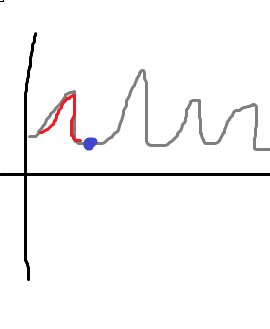

main issue: how to add extra features next to lags

In [16]:
# new pickle data
new_data = pd.read_pickle('../../../data/Bokhoven.pickle')

# sort by time just in case
new_data = new_data.sort_values(by='datetime')

# drop everything unnecessary for now
new_data = new_data[['flow', 'rain_hour', 'Weekday', 'Hour']] # removed month for now
new_data.head()

,flow,rain_hour,Weekday,Hour
0,1200.0,0.0583,Monday,0
1,940.0,0.0448,Monday,1
2,0.0,0.1409,Monday,2
3,280.0,0.0714,Monday,3
4,150.0,0.1340,Monday,4


In [17]:
# normalize flow and rain columns

# first get numpy arrays of flow and rain so that the scaler can be applied
flow = new_data['flow'].to_numpy().reshape(-1, 1)
rain = new_data['rain_hour'].to_numpy().reshape(-1, 1)

# apply the scaler
scaler = MinMaxScaler(feature_range=(0, 1))
flow = scaler.fit_transform(flow)
rain = scaler.fit_transform(rain)

# add columns back to df
new_data['norm_flow'] = flow
new_data['norm_rain'] = rain

# drop old flow and rain cols from df - DON'T DROP, MAKE NEW DATASET INSTEAD
# SAVE ORIGINAL FLOW IN A VARIABLE FOR LATER USE aka TO COMPARE WITH PREDICITONS!!!!!!!!!!!!!
new_data = new_data.drop(['flow', 'rain_hour'], axis=1)

new_data.head()

,Weekday,Hour,norm_flow,norm_rain
0,Monday,0,1.000000,0.002493
1,Monday,1,0.783333,0.001915
2,Monday,2,0.000000,0.006024
3,Monday,3,0.233333,0.003053
4,Monday,4,0.125000,0.005729


In [19]:
# create lags of flow and rain as features for the model

# flow
flow_lags = 24
# These are the "time lags"
shifts = np.arange(1, flow_lags).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data_hour = {"flow_lag_{}_hour".format(hour_shift): new_data.norm_flow.shift(hour_shift) for hour_shift in shifts}

# Convert into a DataFrame for subsequent use
flow_shifts = pd.DataFrame(shifted_data_hour)

# rain
rain_lags = 20
# These are the "time lags"
shifts = np.arange(1, rain_lags).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data_rain = {"rain_lag_{}_hour".format(hour_shift): new_data.norm_rain.shift(hour_shift) for hour_shift in shifts}

# Convert into a DataFrame for subsequent use
rain_shifts = pd.DataFrame(shifted_data_rain)

# combine the shifted data with old data
new_data_shifted = pd.concat([new_data,flow_shifts,rain_shifts], axis=1)

In [20]:
new_data_shifted.head()

,Weekday,Hour,norm_flow,norm_rain,flow_lag_1_hour,flow_lag_2_hour,flow_lag_3_hour,flow_lag_4_hour,flow_lag_5_hour,flow_lag_6_hour,...,rain_lag_10_hour,rain_lag_11_hour,rain_lag_12_hour,rain_lag_13_hour,rain_lag_14_hour,rain_lag_15_hour,rain_lag_16_hour,rain_lag_17_hour,rain_lag_18_hour,rain_lag_19_hour
0,Monday,0,1.000000,0.002493,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Monday,1,0.783333,0.001915,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Monday,2,0.000000,0.006024,0.783333,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Monday,3,0.233333,0.003053,0.000000,0.783333,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Monday,4,0.125000,0.005729,0.233333,0.000000,0.783333,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# get dummies for weekday and hour of the day and combine them with the data
data_shift_dum = pd.get_dummies(new_data_shifted, columns = ['Weekday', 'Hour'])
len1 = len(data_shift_dum)
print('Shape before NAN removal: ', data_shift_dum.shape)

# drop NAN's
data_shift_dum.dropna(inplace=True)
len2 = len(data_shift_dum)
print('Shape after NAN removal:  ', data_shift_dum.shape)
print(len1-len2, 'rows were removed')

Shape before NAN removal:  (14399, 75)
Shape after NAN removal:   (14376, 75)
23 rows were removed


In [42]:
# create the X and y dataset
X = data_shift_dum.iloc[:, 1:] # every columns exept current flow
y = data_shift_dum.iloc[:, :1] # only the current flow columns

# and make them into numpy arrays
X = X.values
y = y.values

In [45]:
# split into train and test set
# here don't shuffle the data, so should have first 80% in train and rest in test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, test_size=.2, shuffle=False, random_state=1)

In [52]:
# reshape X_train and X_test for the LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_test.shape

((11500, 1, 74), (2876, 1, 74))

#### Start with model

In [54]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, 74)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)


Epoch 1/10
 - 13s - loss: 0.0174
Epoch 2/10
 - 12s - loss: 0.0144
Epoch 3/10
 - 13s - loss: 0.0135
Epoch 4/10
 - 13s - loss: 0.0128
Epoch 5/10
 - 13s - loss: 0.0123
Epoch 6/10
 - 13s - loss: 0.0118
Epoch 7/10
 - 13s - loss: 0.0115
Epoch 8/10
 - 12s - loss: 0.0113
Epoch 9/10
 - 12s - loss: 0.0110
Epoch 10/10
 - 12s - loss: 0.0109


In [56]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [68]:
# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
# reshape y_train so that can apply scaler
y_train2 = np.reshape(y_train, (y_train.shape[0], ))
trainY = scaler.inverse_transform([y_train2])

testPredict = scaler.inverse_transform(testPredict)
# same as before
y_test2 = np.reshape(y_test, (y_test.shape[0], ))
testY = scaler.inverse_transform([y_test2])

In [69]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 119.59 RMSE
Test Score: 2.70 RMSE


### complete bullshit follows lol

In [85]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_shift_dum)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[24:len(trainPredict)+24, :] = trainPredict

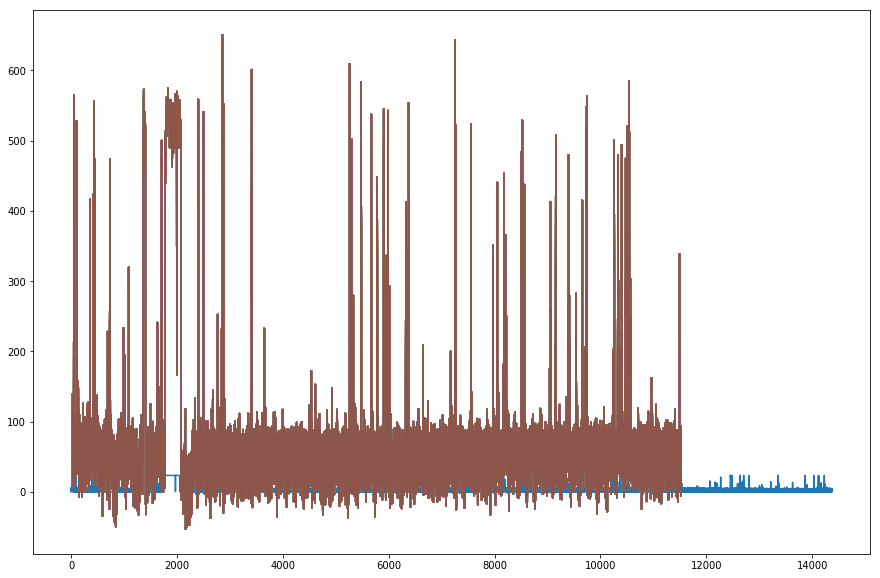

In [86]:
fig = plt.figure(figsize=(15,10))
plt.plot(final)
plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
plt.show()

In [84]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_shift_dum)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(24*2)+1:len(data_shift_dum)-1, :] = testPredict
# plot baseline and predictions
fig = plt.figure(figsize=(15,10))
plt.plot(final)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: could not broadcast input array from shape (2876,1) into shape (2826,75)

In [77]:
org_flow = new_data['norm_flow'].to_numpy().reshape(-1, 1)
org_flow = scaler.inverse_transform(org_flow)
final = org_flow[23:]
final.shape

(14376, 1)

In [81]:
trainPredict.shape, testPredict.shape

((11500, 1), (2876, 1))

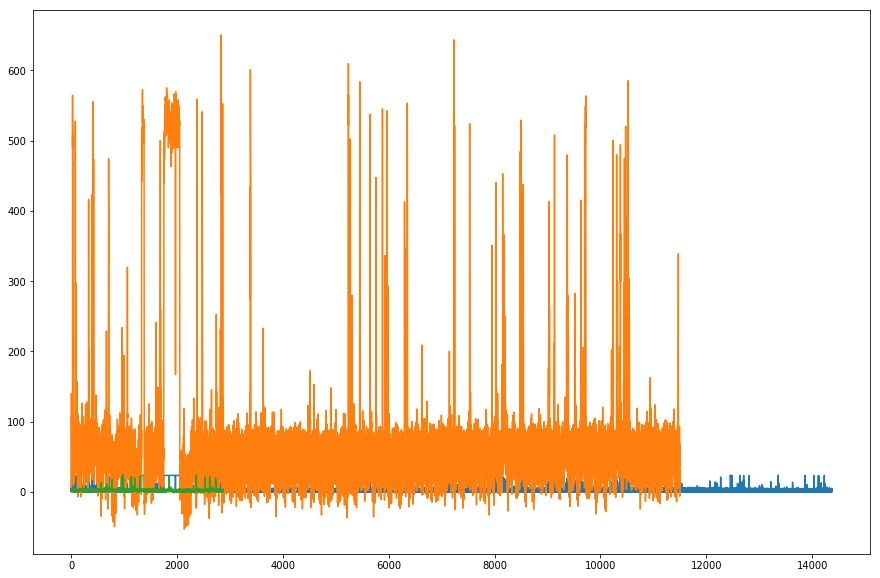

In [82]:
fig = plt.figure(figsize=(15,10))
plt.plot(final)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.show()